In [ ]:
!pip install torch transformers pillow opencv-python easyocr scikit-learn matplotlib seaborn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 27.6 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image, ImageEnhance, ImageFilter
import easyocr
from transformers import (
    AutoTokenizer, AutoModel,
    ViTFeatureExtractor, ViTModel,
    pipeline
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from PIL import Image, ImageEnhance
import numpy as np
import re
import cv2
import copy
import random
from tqdm import tqdm
import torch.nn.functional as F
from collections import Counter
import string
from google.colab import drive
drive.mount('/content/drive')

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 配置路径 - 请根据您的环境修改
# 路径配置
IMAGE_DIR = "/content/drive/MyDrive/Dissertation/images"
CSV_FILE = "/content/drive/MyDrive/Dissertation/labels.csv"
OUTPUT_DIR = "/content/drive/MyDrive/Dissertation/"
CACHE_DIR = "/content/drive/MyDrive/Dissertation/cache"
os.makedirs(CACHE_DIR, exist_ok=True)

Mounted at /content/drive
使用设备: cuda


Original dataset: 6992
Existing image files: 6992
Data distribution:
  Train dataset: 5593 
  Validation dataset: 699 
  Test dataset: 700 

Train Category distribution:
  very_negative: 121
  negative: 384
  neutral: 1761
  positive: 2501
  very_positive: 826

Val Category distribution:
  very_negative: 15
  negative: 48
  neutral: 220
  positive: 313
  very_positive: 103

Test Category distribution:
  very_negative: 15
  negative: 48
  neutral: 220
  positive: 313
  very_positive: 104
EasyOCR successful
Pre-extract all image text...


Extract text: 100%|██████████| 5593/5593 [20:20<00:00,  4.58piece/s]


Text extraction completed! Success rate: 5556/5593 (99.3%)
EasyOCR successful
Pre-extract all image text...


Extract text: 100%|██████████| 699/699 [02:41<00:00,  4.34piece/s]


Text extraction completed! Success rate: 695/699 (99.4%)
EasyOCR successful
Pre-extract all image text...


Extract text: 100%|██████████| 700/700 [02:37<00:00,  4.44piece/s]


Text extraction completed! Success rate: 695/700 (99.3%)
  Raw category counts: [ 121  384 1761 2501  826]
  Minority classes: [0 1 4]
  Enhanced weight: [3.39373633 1.06938046 0.02331869 0.01641912 0.4971454 ]
  Minority oversampling factor: 10
Sampling strategy:
  every epoch samples number: 11186
  number of Minority category: 1331
  Expected number of samples per epoch for the minority category: ~660


Some weights of RobertaModel were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 173,408,278 Total: 62,786,326 can be trainable

 Start testing
Category distribution statistics:
  Category 0 (very_negative): 3528
  Category 1 (negative): 3531
  Category 2 (neutral): 352
  Category 3 (positive): 346
  Category 4 (very_positive): 3429
CBFocalLoss
  Number of samples per class: [3528 3531  352  346 3429]
  CB Weight: [0.38765348 0.38748876 1.89602593 1.91596164 0.41287019]
  Alpha weight: [0.09807256 0.09798924 0.98295455 1.         0.10090405]

Epoch 1/15


Epoch 1 训练: 100%|██████████| 700/700 [03:29<00:00,  3.34batch/s, Loss=2.0109, LR=2.00e-07]



Validation...


Validation: 100%|██████████| 44/44 [00:07<00:00,  6.00batch/s]



Validation set classification report:
               precision    recall  f1-score   support

very_negative     0.0476    0.0667    0.0556        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.3135    0.4545    0.3711       220
     positive     0.4644    0.5208    0.4910       313
very_positive     0.0000    0.0000    0.0000       103

     accuracy                         0.3777       699
    macro avg     0.1651    0.2084    0.1835       699
 weighted avg     0.3076    0.3777    0.3378       699


Epoch 1 results:
Training loss: 1.8005
Training F1 score: 0.2245
Training Macro F1 score: 0.1620
Validation loss: 0.8581
Validation accuracy: 0.3777 (37.77%)
Validation F1 score: 0.3378
Validation Macro F1 score: 0.1835
IMPROVING ★

Epoch 2/15


Epoch 2 训练: 100%|██████████| 700/700 [03:40<00:00,  3.17batch/s, Loss=1.4404, LR=2.00e-07]



Validation...


Validation: 100%|██████████| 44/44 [00:07<00:00,  6.09batch/s]



Validation set classification report:
               precision    recall  f1-score   support

very_negative     0.0000    0.0000    0.0000        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.3223    0.5773    0.4137       220
     positive     0.4551    0.4377    0.4463       313
very_positive     0.0000    0.0000    0.0000       103

     accuracy                         0.3777       699
    macro avg     0.1555    0.2030    0.1720       699
 weighted avg     0.3053    0.3777    0.3300       699


Epoch 2 results:
Training loss: 1.6964
Training F1 score: 0.2059
Training Macro F1 score: 0.1518
Validation loss: 0.7142
Validation accuracy: 0.3777 (37.77%)
Validation F1 score: 0.3300
Validation Macro F1 score: 0.1720
did not improve (1/6)

Epoch 3/15


Epoch 3 训练: 100%|██████████| 700/700 [03:30<00:00,  3.33batch/s, Loss=3.7318, LR=2.00e-07]



Validation...


Validation: 100%|██████████| 44/44 [00:07<00:00,  6.02batch/s]



Validation set classification report:
               precision    recall  f1-score   support

very_negative     0.0000    0.0000    0.0000        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.2994    0.4545    0.3610       220
     positive     0.4503    0.5208    0.4830       313
very_positive     0.0000    0.0000    0.0000       103

     accuracy                         0.3763       699
    macro avg     0.1499    0.1951    0.1688       699
 weighted avg     0.2959    0.3763    0.3299       699


Epoch 3 results:
Training loss: 1.6525
Training F1 score: 0.1900
Training Macro F1 score: 0.1415
Validation loss: 0.6912
Validation accuracy: 0.3763 (37.63%)
Validation F1 score: 0.3299
Validation Macro F1 score: 0.1688
did not improve (2/6)

Epoch 4/15


Epoch 4 训练: 100%|██████████| 700/700 [03:30<00:00,  3.33batch/s, Loss=1.4768, LR=2.00e-07]



Validation...


Validation: 100%|██████████| 44/44 [00:07<00:00,  5.99batch/s]



Validation set classification report:
               precision    recall  f1-score   support

very_negative     0.0000    0.0000    0.0000        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.3003    0.5091    0.3777       220
     positive     0.4414    0.4569    0.4490       313
very_positive     0.0000    0.0000    0.0000       103

     accuracy                         0.3648       699
    macro avg     0.1483    0.1932    0.1653       699
 weighted avg     0.2921    0.3648    0.3199       699


Epoch 4 results:
Training loss: 1.6056
Training F1 score: 0.1817
Training Macro F1 score: 0.1397
Validation loss: 0.6816
Validation accuracy: 0.3648 (36.48%)
Validation F1 score: 0.3199
Validation Macro F1 score: 0.1653
did not improve (3/6)

Epoch 5/15


Epoch 5 训练: 100%|██████████| 700/700 [03:30<00:00,  3.33batch/s, Loss=1.3884, LR=2.00e-07]



Validation...


Validation: 100%|██████████| 44/44 [00:07<00:00,  6.05batch/s]



Validation set classification report:
               precision    recall  f1-score   support

very_negative     0.0000    0.0000    0.0000        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.3111    0.7000    0.4308       220
     positive     0.4335    0.2812    0.3411       313
very_positive     0.0000    0.0000    0.0000       103

     accuracy                         0.3462       699
    macro avg     0.1489    0.1962    0.1544       699
 weighted avg     0.2920    0.3462    0.2883       699


Epoch 5 results:
Training loss: 1.5692
Training F1 score: 0.1959
Training Macro F1 score: 0.1463
Validation loss: 0.7203
Validation accuracy: 0.3462 (34.62%)
Validation F1 score: 0.2883
Validation Macro F1 score: 0.1544
did not improve (4/6)

Epoch 6/15


Epoch 6 训练: 100%|██████████| 700/700 [03:30<00:00,  3.33batch/s, Loss=1.3559, LR=1.60e-07]



Validation...


Validation: 100%|██████████| 44/44 [00:07<00:00,  5.98batch/s]



Validation set classification report:
               precision    recall  f1-score   support

very_negative     0.0000    0.0000    0.0000        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.3162    0.8091    0.4547       220
     positive     0.4776    0.2045    0.2864       313
very_positive     0.0000    0.0000    0.0000       103

     accuracy                         0.3462       699
    macro avg     0.1588    0.2027    0.1482       699
 weighted avg     0.3134    0.3462    0.2713       699


Epoch 6 results:
Training loss: 1.5326
Training F1 score: 0.1956
Training Macro F1 score: 0.1460
Validation loss: 0.7704
Validation accuracy: 0.3462 (34.62%)
Validation F1 score: 0.2713
Validation Macro F1 score: 0.1482
did not improve (5/6)

Epoch 7/15


Epoch 7 训练: 100%|██████████| 700/700 [03:30<00:00,  3.33batch/s, Loss=1.3602, LR=1.60e-07]



Validation...


Validation: 100%|██████████| 44/44 [00:07<00:00,  5.97batch/s]



Validation set classification report:
               precision    recall  f1-score   support

very_negative     0.0000    0.0000    0.0000        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.3203    0.6318    0.4251       220
     positive     0.4809    0.4026    0.4383       313
very_positive     0.0000    0.0000    0.0000       103

     accuracy                         0.3791       699
    macro avg     0.1602    0.2069    0.1727       699
 weighted avg     0.3161    0.3791    0.3300       699


Epoch 7 results:
Training loss: 1.5104
Training F1 score: 0.1977
Training Macro F1 score: 0.1475
Validation loss: 0.7910
Validation accuracy: 0.3791 (37.91%)
Validation F1 score: 0.3300
Validation Macro F1 score: 0.1727
did not improve (6/6)

 Early stop trigger based on Macro F1! Continuous 6 epoch does not improve

 saving path: /content/drive/MyDrive/Dissertation/training_results.csv

 Loading the best model for testing...
Start final testing


testing: 100%|██████████| 44/44 [00:07<00:00,  6.07batch/s]



=== Final test results ===
Test accuracy: 0.3600 (36.00%)
Test Weighted F1: 0.3156

 Detailed classification report of the test set:
               precision    recall  f1-score   support

very_negative     0.0000    0.0000    0.0000        15
     negative     0.0000    0.0000    0.0000        48
      neutral     0.2897    0.4227    0.3438       220
     positive     0.4274    0.5080    0.4642       313
very_positive     0.0000    0.0000    0.0000       104

     accuracy                         0.3600       700
    macro avg     0.1434    0.1861    0.1616       700
 weighted avg     0.2822    0.3600    0.3156       700

Test results saved to /content/drive/MyDrive/Dissertation/test_results.csv

 Generate interpretable visualizations...
Processing samples 1...
Image attention shape: torch.Size([1, 196])
Num patches: 196, Grid size: 14
Successfully generated 14x14 heatmap
Filtered tokens: 21 out of 24 valid tokens
save: /content/drive/MyDrive/Dissertation/enhanced_attention_visualiza

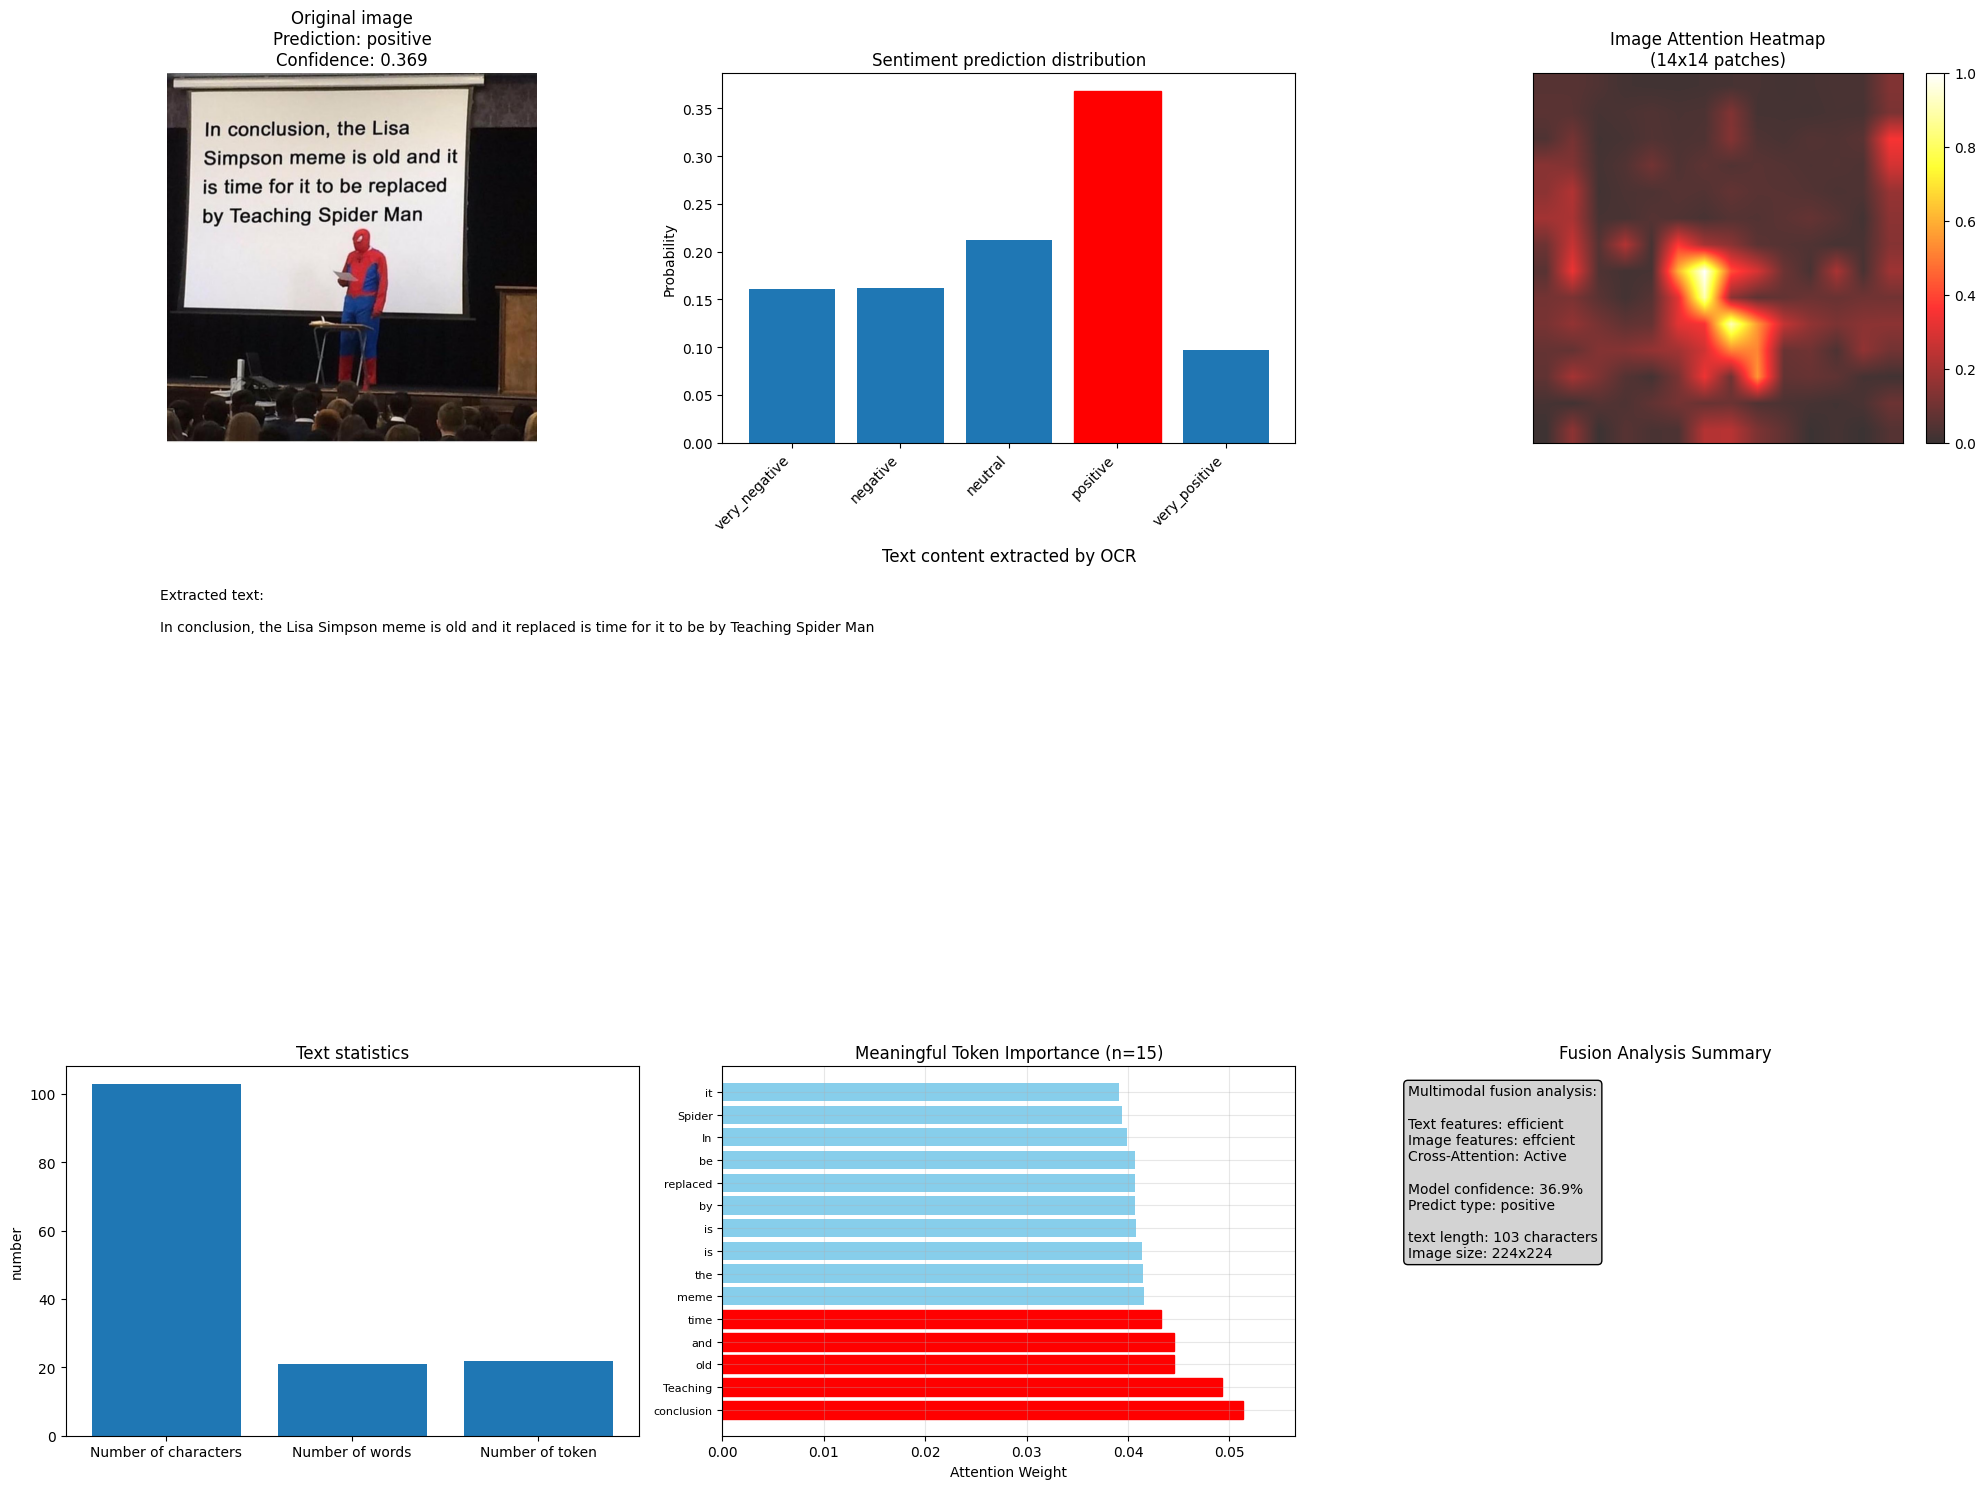

Processing samples 2...
Image attention shape: torch.Size([1, 196])
Num patches: 196, Grid size: 14
Successfully generated 14x14 heatmap
Filtered tokens: 12 out of 15 valid tokens
save: /content/drive/MyDrive/Dissertation/enhanced_attention_visualization_sample_2.png


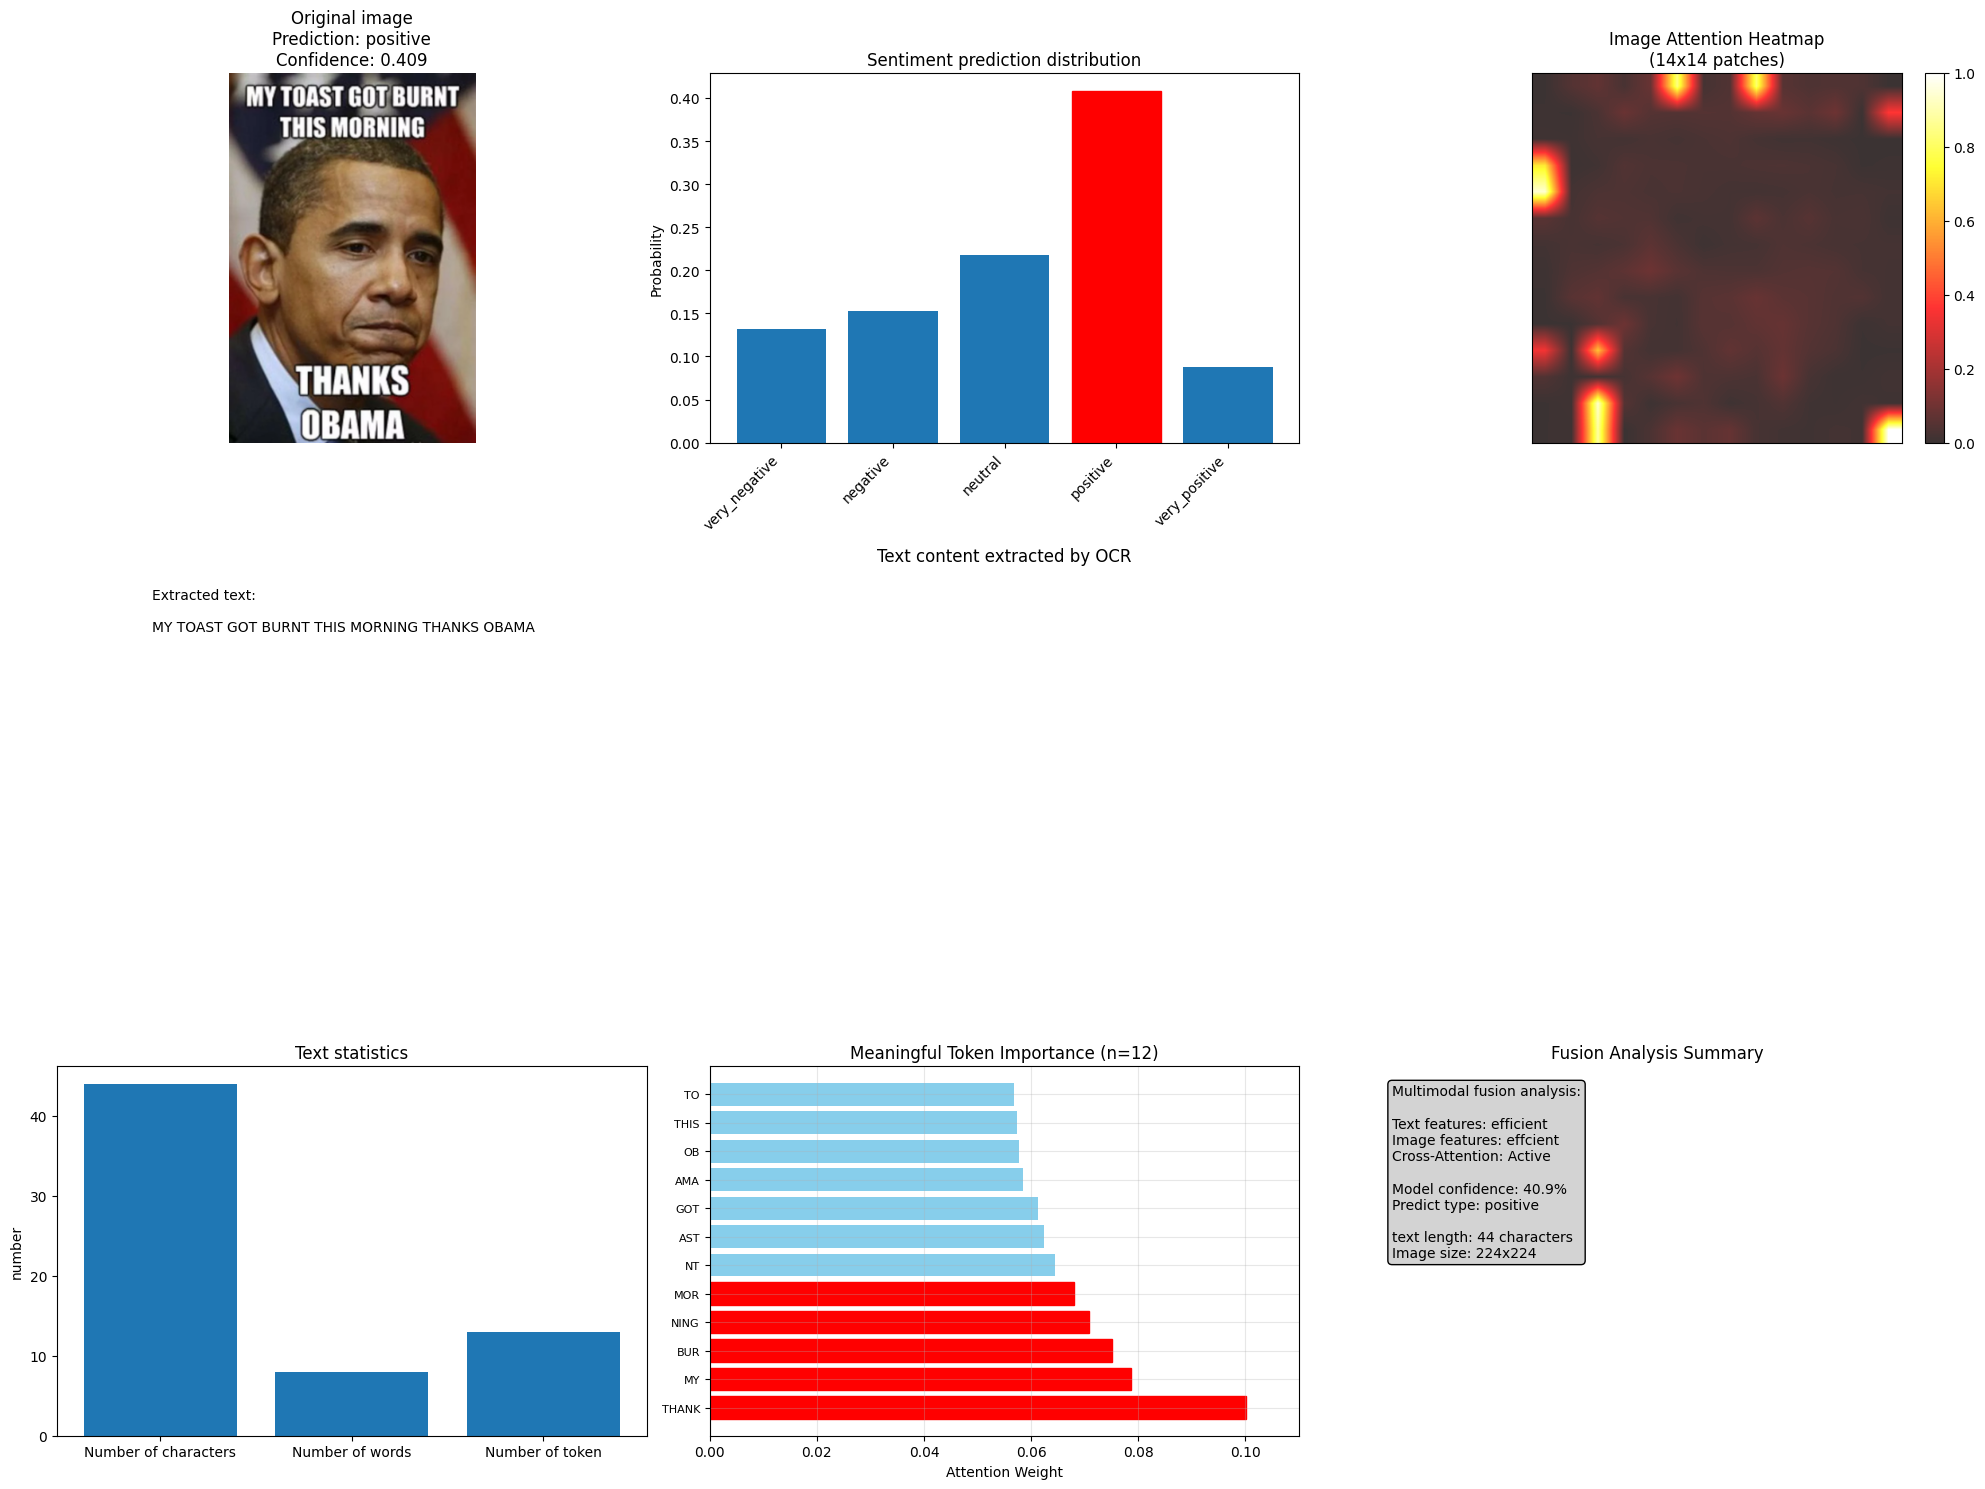

Processing samples 3...
Image attention shape: torch.Size([1, 196])
Num patches: 196, Grid size: 14
Successfully generated 14x14 heatmap
Filtered tokens: 19 out of 24 valid tokens
save: /content/drive/MyDrive/Dissertation/enhanced_attention_visualization_sample_3.png


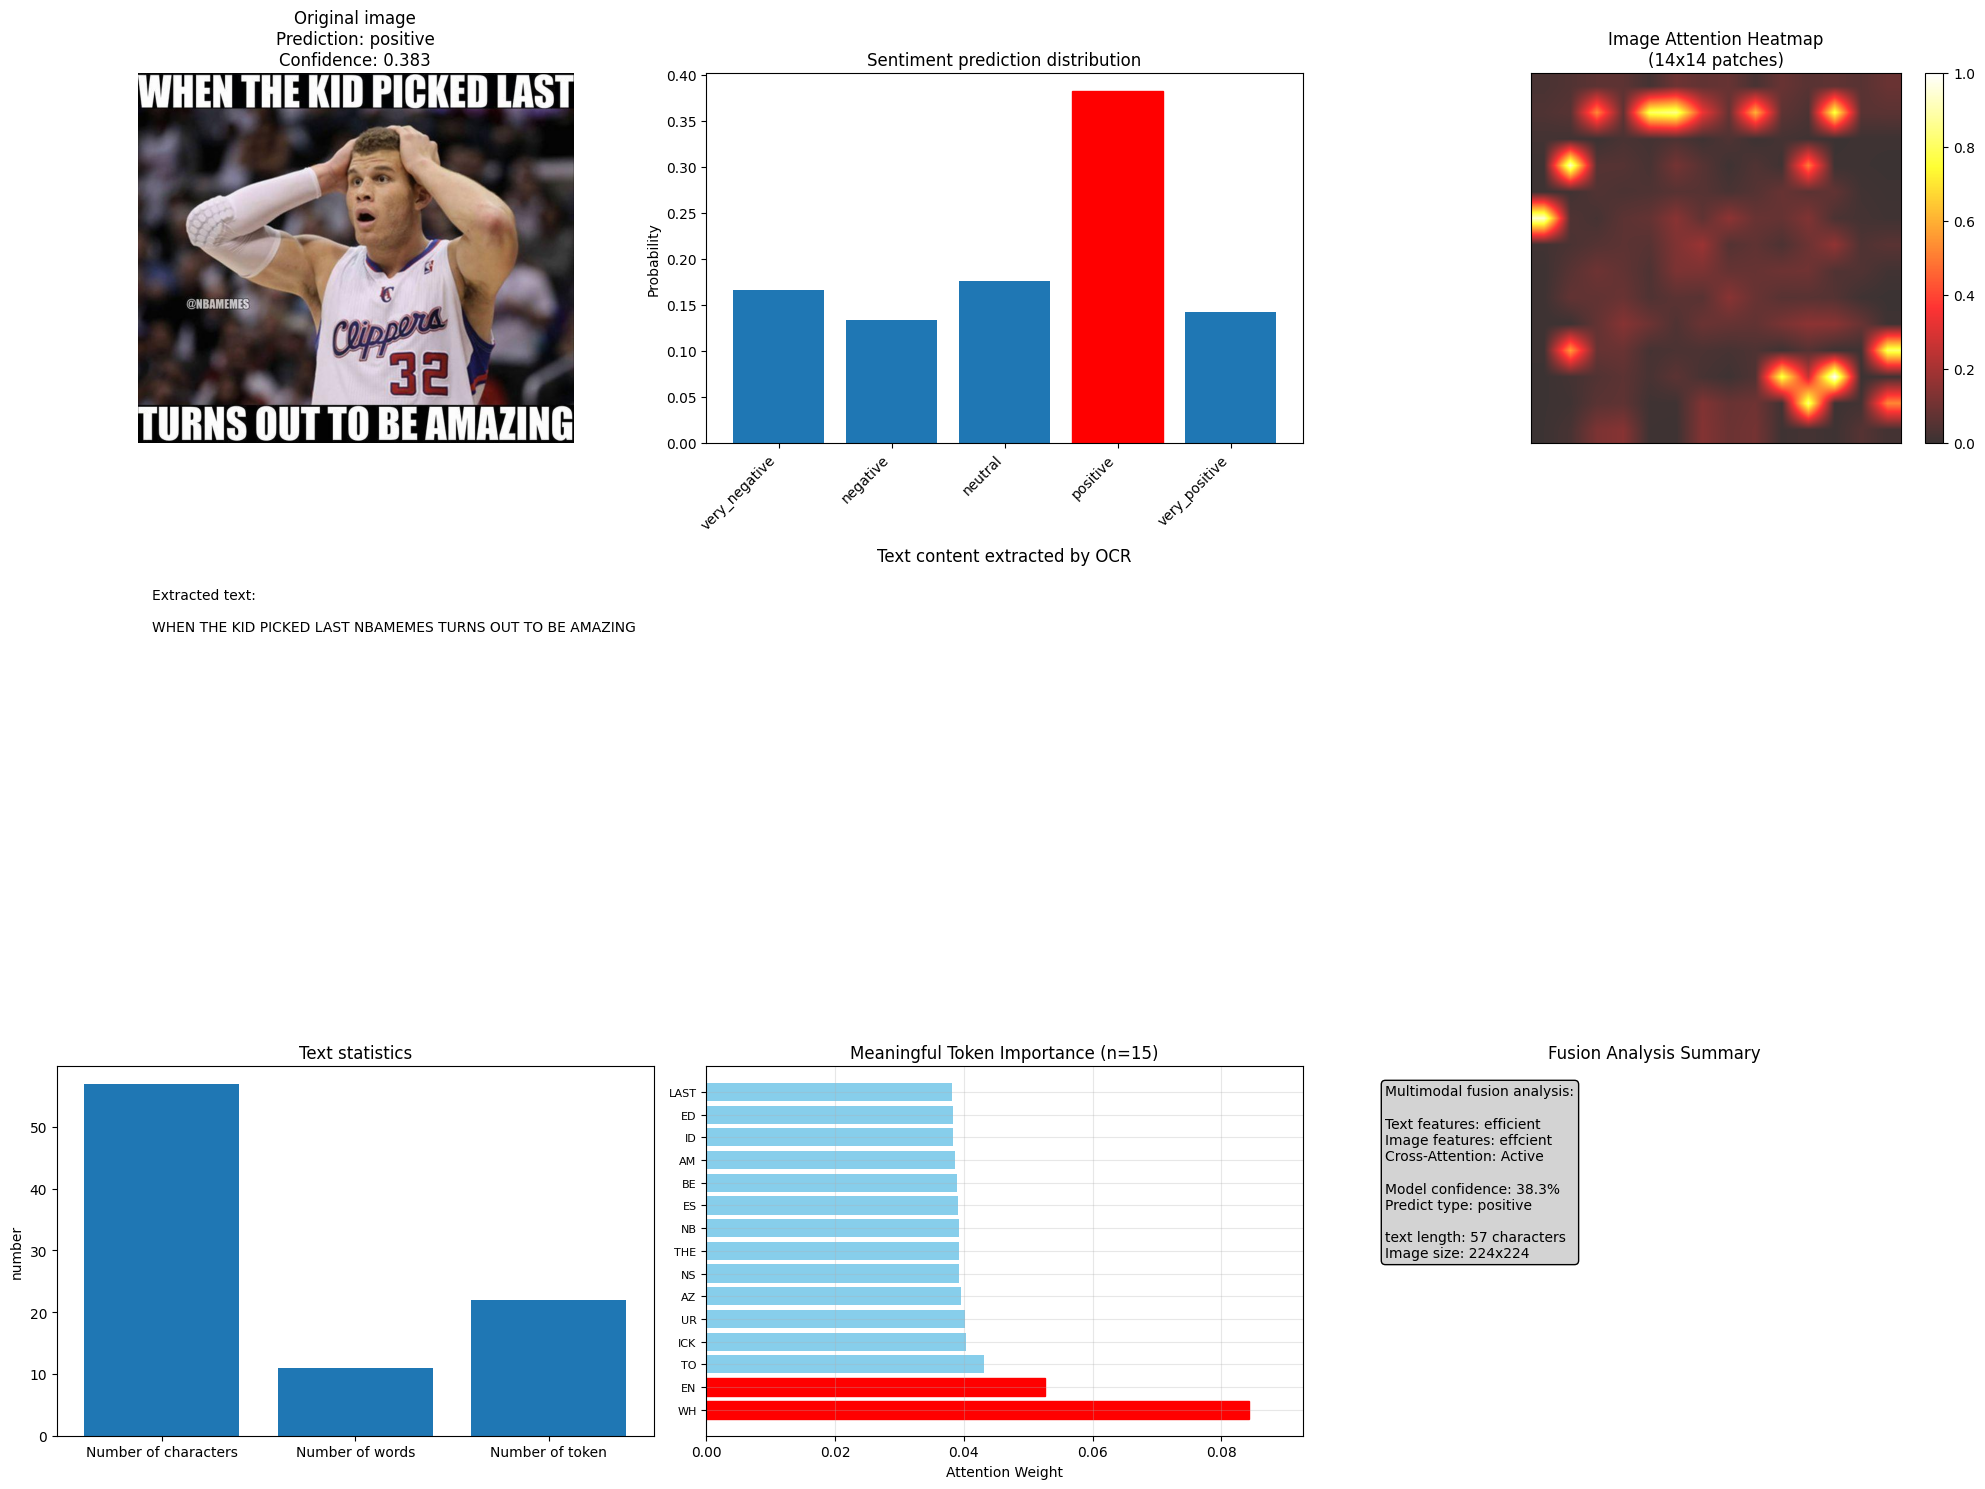

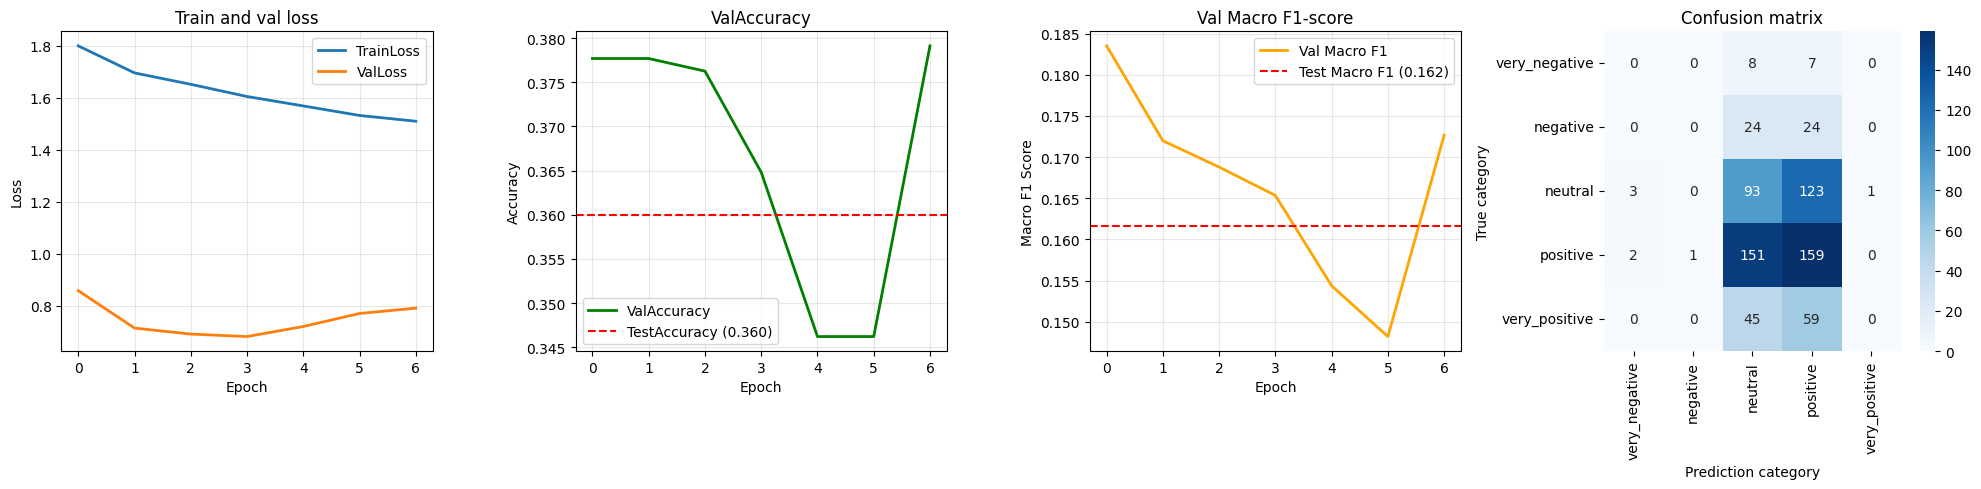

Best model: /content/drive/MyDrive/Dissertation/best_enhanced_meme_model.pth
Training CSV: /content/drive/MyDrive/Dissertation/training_results.csv
Tesing CSV: /content/drive/MyDrive/Dissertation/test_results.csv
Training image: /content/drive/MyDrive/Dissertation/enhanced_training_analysis.png
Visulization: /content/drive/MyDrive/Dissertation/enhanced_attention_visualization_sample_*.png
all models: /content/drive/MyDrive/Dissertation/model_summary.csv

 Training finished. Saving path: /content/drive/MyDrive/Dissertation/


In [ ]:
def clean_easyocr_text(text):
    """
    清理EasyOCR的输出文本
    """
    if not text:
        return ""

    # EasyOCR通常给出更好的结果，所以清理要保守一些

    # 移除首尾空白
    text = text.strip()

    # 只移除明显的噪声字符
    text = re.sub(r'[^\w\s.,!?;:()\'-]', ' ', text)

    # 清理多余空格
    text = ' '.join(text.split())

    # 如果文本太短或者全是特殊字符，返回空
    if len(text) < 2 or not any(c.isalpha() for c in text):
        return ""

    return text

def extract_text_with_easyocr(image_path, reader):
    """
    使用EasyOCR提取meme图像文本
    """
    try:
        # 直接使用EasyOCR读取图像
        results = reader.readtext(image_path)

        if not results:
            return ""

        # 按照文本在图像中的位置排序（从上到下）
        # EasyOCR返回格式：(bbox, text, confidence)
        sorted_results = sorted(results, key=lambda x: x[0][0][1])  # 按y坐标排序

        # 收集高置信度的文本
        texts = []
        for bbox, text, confidence in sorted_results:
            # 只保留置信度较高的文本
            if confidence > 0.5:  # EasyOCR的置信度阈值
                # 清理文本
                cleaned_text = clean_easyocr_text(text)
                if cleaned_text and len(cleaned_text) > 1:
                    texts.append(cleaned_text)

        return ' '.join(texts) if texts else ""

    except Exception as e:
        print(f"EasyOCR处理 {os.path.basename(image_path)} 时出错: {str(e)}")
        return ""

def extract_with_preprocessing(image_path, reader):
    """
    对图像进行预处理后使用EasyOCR
    """
    try:
        # 读取和预处理图像
        img = cv2.imread(image_path)
        if img is None:
            return ""

        # 放大图像（EasyOCR在大图上效果更好）
        height, width = img.shape[:2]
        if min(height, width) < 500:
            scale = 500 / min(height, width)
            new_width = int(width * scale)
            new_height = int(height * scale)
            img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

        # 增强对比度
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        l = clahe.apply(l)
        enhanced = cv2.merge([l, a, b])
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)

        # 使用EasyOCR处理增强后的图像
        results = reader.readtext(enhanced)

        # 处理结果
        texts = []
        for bbox, text, confidence in results:
            if confidence > 0.3:
                cleaned_text = clean_easyocr_text(text)
                if cleaned_text and len(cleaned_text) > 1:
                    texts.append(cleaned_text)

        # 按位置排序
        if results:
            sorted_results = sorted(
                [(bbox, text, conf) for bbox, text, conf in results if conf > 0.3],
                key=lambda x: x[0][0][1]  # 按y坐标排序
            )
            texts = [clean_easyocr_text(text) for bbox, text, conf in sorted_results
                    if clean_easyocr_text(text) and len(clean_easyocr_text(text)) > 1]

        return ' '.join(texts) if texts else ""

    except Exception as e:
        return ""

def extract_meme_text(image_path, reader):
    """
    组合多种方法提取meme文本
    """
    # 方法1：直接使用EasyOCR
    text1 = extract_text_with_easyocr(image_path, reader)

    # 方法2：预处理后使用EasyOCR
    text2 = extract_with_preprocessing(image_path, reader)

    # 选择更好的结果
    if len(text2) > len(text1) and len(text2) > 5:
        return text2
    elif len(text1) > 5:
        return text1
    else:
        # 如果两种方法都不理想，返回较长的那个
        return text2 if len(text2) > len(text1) else text1

class EnhancedMemeDataset(Dataset):
    def __init__(self, image_paths, labels, tokenizer, feature_extractor, max_length=256):
        self.image_paths = image_paths
        self.labels = labels
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = max_length

        # 初始化EasyOCR读取器（英文和中文）
        try:
            self.ocr_reader = easyocr.Reader(['en'], gpu=torch.cuda.is_available())
            print("EasyOCR successful")
        except Exception as e:
            print(f"EasyOCR error: {e}")
            raise

        # 预提取所有文本以提高效率
        print("Pre-extract all image text...")
        self.cached_texts = {}

        # 使用进度条显示文本提取进度
        for i, path in enumerate(tqdm(image_paths, desc="Extract text", unit="piece")):
            self.cached_texts[path] = self.extract_text_from_image(path)

        success_count = sum(1 for text in self.cached_texts.values()
                          if text and text not in ["[NO_TEXT_FOUND]", "[OCR_ERROR]"])
        print(f"Text extraction completed! Success rate: {success_count}/{len(image_paths)} ({success_count/len(image_paths)*100:.1f}%)")

    def extract_text_from_image(self, image_path):
        """使用EasyOCR从图像中提取文本"""
        try:
            # 使用改进的EasyOCR提取方法
            extracted_text = extract_meme_text(image_path, self.ocr_reader)

            # 文本清理
            if extracted_text:
                extracted_text = extracted_text.replace('\n', ' ').replace('\t', ' ')
                extracted_text = ' '.join(extracted_text.split())  # 去除多余空白

            return extracted_text.strip() if extracted_text and extracted_text.strip() else "[NO_TEXT_FOUND]"

        except Exception as e:
            print(f"OCR extraction error {image_path}: {e}")
            return "[OCR_ERROR]"

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # 获取缓存的文本
        text = self.cached_texts.get(image_path, "[NO_TEXT]")

        # 简单的文本增强：随机 token dropout（以提高鲁棒性）
        # 小概率删除一些单词（p=0.05），只在训练时有益；这里不依赖外部train/eval标识，随机性不会破坏验证稳定性
        try:
            if isinstance(text, str) and len(text.split()) > 3:
                if random.random() < 0.2:  # 20% 的样本应用微增强
                    words = text.split()
                    keep = []
                    for w in words:
                        if random.random() < 0.95:  # 5% 概率丢弃单词
                            keep.append(w)
                    new_text = ' '.join(keep).strip()
                    if len(new_text) >= 2:
                        text = new_text
        except Exception:
            pass

        # 文本编码（保持原有 tokenizer 使用）
        text_encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # 图像处理 - 改进的错误处理
        try:
            image = Image.open(image_path)

            if image.mode != 'RGB':
                image = image.convert('RGB')

            # 在这里应用图像增强（随机性有助于正则化）
            image = self.enhance_image(image)

            # 特征提取
            image_encoding = self.feature_extractor(image, return_tensors='pt')

        except Exception as e:
            print(f"error {image_path}: {e}")
            # fallback 白图
            try:
                image = Image.new('RGB', (224, 224), color=(255, 255, 255))
                image_encoding = self.feature_extractor(image, return_tensors='pt')
            except Exception as e2:
                print(f"error {e2}")
                image_encoding = {
                    'pixel_values': torch.zeros((3, 224, 224), dtype=torch.float32)
                }

        return {
            'text_input_ids': text_encoding['input_ids'].squeeze(),
            'text_attention_mask': text_encoding['attention_mask'].squeeze(),
            'image_pixel_values': image_encoding['pixel_values'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long),
            'text': text,
            'image_path': image_path
        }

    def enhance_image(self, image):
        """图像预处理增强 - 修复版本，完全使用PIL避免OpenCV问题"""
        try:
            # 保证 RGB
            if image.mode != 'RGB':
                image = image.convert('RGB')

            # 基础的训练阶段变换（非确定性）
            transform_list = []

            # 随机缩放裁剪（有助于不同文本位置的鲁棒性）
            transform_list.append(transforms.RandomResizedCrop(224, scale=(0.8, 1.0)))

            # 随机水平翻转（meme中很多文本不依赖左右，使用小概率）
            transform_list.append(transforms.RandomHorizontalFlip(p=0.5))

            # 颜色抖动（brightness/contrast/saturation）
            transform_list.append(transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02))

            # 轻微锐化仍保留（你原来的 unsharp）
            # 但用 PIL 的滤镜作为最后一步
            transform = transforms.Compose(transform_list + [
                transforms.Resize((224,224)),
            ])

            pil_transformed = transform(image)

            # 使用UnsharpMask作为最后一步（保留你原来的锐化思想）
            from PIL import ImageFilter
            pil_transformed = pil_transformed.filter(ImageFilter.UnsharpMask(radius=1, percent=120, threshold=1))

            return pil_transformed

        except Exception as e:
            print(f"Image enhancement failed, returning the original image: {e}")
            return image.convert('RGB') if image.mode != 'RGB' else image

class AdvancedCrossModalAttention(nn.Module):
    def __init__(self, text_dim, image_dim, hidden_dim=512, num_heads=8):
        super(AdvancedCrossModalAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads

        # 模态对齐层
        self.text_proj = nn.Sequential(
            nn.Linear(text_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.image_proj = nn.Sequential(
            nn.Linear(image_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # 多头注意力机制
        self.text_to_image_attn = nn.MultiheadAttention(
            hidden_dim, num_heads=num_heads, dropout=0.1, batch_first=True
        )
        self.image_to_text_attn = nn.MultiheadAttention(
            hidden_dim, num_heads=num_heads, dropout=0.1, batch_first=True
        )

        # 残差连接和层归一化
        self.text_norm = nn.LayerNorm(hidden_dim)
        self.image_norm = nn.LayerNorm(hidden_dim)

        # 门控机制
        self.text_gate = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Dropout(0.3),
            nn.Sigmoid()
        )
        self.image_gate = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Dropout(0.3),
            nn.Sigmoid()
        )

    def forward(self, text_features, image_features):
        batch_size = text_features.size(0)

        # 特征投影
        text_proj = self.text_proj(text_features)  # [batch, hidden_dim]
        image_proj = self.image_proj(image_features)  # [batch, hidden_dim]

        # 扩展维度用于注意力计算
        text_proj = text_proj.unsqueeze(1)  # [batch, 1, hidden_dim]
        image_proj = image_proj.unsqueeze(1)  # [batch, 1, hidden_dim]

        # 交叉注意力
        text_attended, text_attn_weights = self.text_to_image_attn(
            text_proj, image_proj, image_proj
        )
        image_attended, image_attn_weights = self.image_to_text_attn(
            image_proj, text_proj, text_proj
        )

        # 残差连接
        text_attended = self.text_norm(text_attended + text_proj)
        image_attended = self.image_norm(image_attended + image_proj)

        # 门控融合
        text_original = text_proj.squeeze(1)
        image_original = image_proj.squeeze(1)
        text_attended_flat = text_attended.squeeze(1)
        image_attended_flat = image_attended.squeeze(1)

        # 计算门控权重
        text_gate_input = torch.cat([text_original, text_attended_flat], dim=-1)
        image_gate_input = torch.cat([image_original, image_attended_flat], dim=-1)

        text_gate_weight = self.text_gate(text_gate_input)
        image_gate_weight = self.image_gate(image_gate_input)

        # 应用门控
        text_final = text_gate_weight * text_attended_flat + (1 - text_gate_weight) * text_original
        image_final = image_gate_weight * image_attended_flat + (1 - image_gate_weight) * image_original

        return text_final, image_final, text_attn_weights, image_attn_weights

def calculate_class_distribution(labels, num_classes=5):
    # Calculate the category distribution to ensure that all categories are included
    # 使用 bincount 统计，并确保长度为 num_classes
    class_counts = np.bincount(labels, minlength=num_classes)

    # 只取前 num_classes 个（防止超出）
    samples_per_class = class_counts[:num_classes]

    print(f"Category distribution statistics:")
    emotion_labels = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
    for i, count in enumerate(samples_per_class):
        print(f"  Category {i} ({emotion_labels[i]}): {count}")

    return samples_per_class

class CBFocalLoss(nn.Module):
    def __init__(self, samples_per_class, num_classes, beta=0.99, gamma=2.5, alpha=None, reduction='mean'):
        super(CBFocalLoss, self).__init__()
        samples_per_class = np.maximum(samples_per_class, 1)

        # 更激进的重平衡策略
        effective_num = 1.0 - np.power(beta, samples_per_class)
        weights = (1.0 - beta) / effective_num

        # 对少数类给予更大权重
        min_samples = np.min(samples_per_class)
        max_samples = np.max(samples_per_class)
        ratio = max_samples / (samples_per_class + 1e-6)

        # 结合effective number和sample ratio
        combined_weights = weights * (ratio ** 0.5)
        combined_weights[2] *= 1.5
        combined_weights[3] *= 1.5
        combined_weights[4] *= 1.05
        combined_weights = combined_weights / np.sum(combined_weights) * num_classes

        self.class_weights = torch.tensor(combined_weights, dtype=torch.float32)
        self.num_classes = num_classes
        self.gamma = gamma
        self.reduction = reduction

        # Focal loss的alpha参数，进一步增强少数类
        if alpha is None:
            # 自适应alpha：少数类更大的alpha
            inv_freq = 1.0 / (samples_per_class + 1e-6)
            alpha = inv_freq / inv_freq.sum()
            alpha = alpha / alpha.max()  # 归一化到[0,1]

        self.alpha = torch.tensor(alpha, dtype=torch.float32)

        print(f"CBFocalLoss")
        print(f"  Number of samples per class: {samples_per_class}")
        print(f"  CB Weight: {combined_weights}")
        print(f"  Alpha weight: {alpha}")

    def forward(self, logits, labels):
        device = logits.device
        weights = self.class_weights.to(device)
        alpha = self.alpha.to(device)

        # 计算交叉熵
        log_probs = F.log_softmax(logits, dim=1)
        ce_loss = F.nll_loss(log_probs, labels, reduction='none')

        probs = torch.exp(log_probs)
        pt = probs.gather(1, labels.unsqueeze(1)).squeeze(1)
        pt = torch.clamp(pt, min=1e-7, max=1.0)

        focal_term = (1 - pt) ** self.gamma
        alpha_t = alpha[labels]
        cb_weights = weights[labels]

        # 组合所有项
        loss = alpha_t * cb_weights * focal_term * ce_loss

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

def create_balanced_sampler(labels, minority_oversample_factor=8):
    """
    创建高度平衡的采样器，专门提升minority classes的采样
    """
    labels = np.array(labels)
    class_counts = np.bincount(labels, minlength=5)

    # 识别minority classes (样本数 < 500的类别)
    minority_threshold = 900
    minority_classes = np.where(class_counts < minority_threshold)[0]

    # 为每个类别计算采样权重
    base_weights = 1.0 / (class_counts + 1e-6)

    # 对minority classes给予额外权重
    enhanced_weights = base_weights.copy()
    for cls_idx in minority_classes:
        enhanced_weights[cls_idx] *= minority_oversample_factor

    # 归一化权重
    enhanced_weights = enhanced_weights / enhanced_weights.sum() * len(enhanced_weights)

    # 为每个样本分配权重
    sample_weights = [enhanced_weights[label] for label in labels]

    print(f"  Raw category counts: {class_counts}")
    print(f"  Minority classes: {minority_classes}")
    print(f"  Enhanced weight: {enhanced_weights}")
    print(f"  Minority oversampling factor: {minority_oversample_factor}")

    return sample_weights

class EnhancedMultiModalEmotionClassifier(nn.Module):
    def __init__(self, num_classes=5, hidden_dim=256):
        super(EnhancedMultiModalEmotionClassifier, self).__init__()

        emotion_model_name = 'j-hartmann/emotion-english-distilroberta-base'
        try:
            self.text_encoder = AutoModel.from_pretrained(emotion_model_name)
            self.tokenizer_type = 'emotion-specific'
        except:
            self.text_encoder = AutoModel.from_pretrained('roberta-base')
            self.tokenizer_type = 'roberta'

        self.text_dim = self.text_encoder.config.hidden_size

        self.image_encoder = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.image_dim = self.image_encoder.config.hidden_size

        self._freeze_more_layers()

        # 交叉注意力
        self.cross_modal_attention = AdvancedCrossModalAttention(
            self.text_dim, self.image_dim, hidden_dim
        )

        # 更保守的融合网络：更强的dropout + 降维以减少过拟合
        self.fusion_network = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.4),
        )

        self.classifier_head1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 4, num_classes)
        )

        self.classifier_head2 = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        # 融合权重
        self.head_fusion = nn.Sequential(
            nn.Linear(hidden_dim // 2, 2),
            nn.Softmax(dim=-1)
        )

        self.text_aux_classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_classes)
        )
        self.image_aux_classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        self._init_weights()

    def _init_weights(self):
        for module in [self.fusion_network, self.classifier_head1, self.classifier_head2, self.text_aux_classifier, self.image_aux_classifier]:
            for m in module.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)

    def _freeze_more_layers(self):
        """冻结预训练模型的早期层"""
        # 冻结文本编码器的前6层
        for param in self.text_encoder.embeddings.parameters():
            param.requires_grad = False

        if hasattr(self.text_encoder, 'encoder'):
            total_layers = len(self.text_encoder.encoder.layer)
            freeze_layers = min(8, max(total_layers - 4, 0))  # 至少保留4层可训练
            for layer in self.text_encoder.encoder.layer[:freeze_layers]:
                for param in layer.parameters():
                    param.requires_grad = False

        # 冻结图像编码器的前8层（降低到8层）
        if hasattr(self.image_encoder, 'embeddings'):
            for param in self.image_encoder.embeddings.parameters():
                param.requires_grad = False

        if hasattr(self.image_encoder, 'encoder'):
            total_layers = len(self.image_encoder.encoder.layer)
            freeze_layers = min(8, max(total_layers - 4, 0))  # 至少保留4层可训练
            for layer in self.image_encoder.encoder.layer[:freeze_layers]:
                for param in layer.parameters():
                    param.requires_grad = False

    def forward(self, text_input_ids, text_attention_mask, image_pixel_values, return_aux=False):
        if self.tokenizer_type == 'roberta':
            text_input_ids = text_input_ids.masked_fill(text_input_ids == 1, 0)

        text_outputs = self.text_encoder(
            input_ids=text_input_ids,
            attention_mask=text_attention_mask,
            output_attentions=True
        )

        text_embeddings = text_outputs.last_hidden_state
        text_mask = text_attention_mask.unsqueeze(-1).expand(text_embeddings.size()).float()
        text_features = (text_embeddings * text_mask).sum(1) / text_mask.sum(1)

        text_attentions = text_outputs.attentions
        if text_attentions and len(text_attentions) > 0:
            last_layer_attention = text_attentions[-1]  # [batch, heads, seq_len, seq_len]

            # 使用CLS token注意力方法
            avg_attention = last_layer_attention.mean(dim=1)  # [batch, seq_len, seq_len]
            cls_attention = avg_attention[:, 0, :]  # [batch, seq_len]

            # 应用attention mask过滤padding
            masked_attention = cls_attention * text_attention_mask.float()

            # 增强对比度使差异更明显
            for i in range(masked_attention.size(0)):
                valid_positions = text_attention_mask[i].bool()
                if valid_positions.sum() > 1:
                    valid_attn = masked_attention[i][valid_positions]
                    if valid_attn.max() > valid_attn.min():
                        enhanced_attn = torch.softmax(valid_attn * 2.5, dim=0)
                        masked_attention[i][valid_positions] = enhanced_attn

            text_attn_weights = masked_attention
        else:
            text_attn_weights = None

        # 图像编码
        image_outputs = self.image_encoder(pixel_values=image_pixel_values, output_attentions=True)
        image_features = image_outputs.last_hidden_state[:, 0]

        image_attentions = image_outputs.attentions
        if image_attentions and len(image_attentions) > 0:
            # 取最后一层的attention: [batch, heads, patches, patches]
            last_layer_attention = image_attentions[-1]
            # print(f"Image attention raw shape: {last_layer_attention.shape}")

            # 确保形状正确
            if len(last_layer_attention.shape) == 4 and last_layer_attention.shape[2] > 1:
                # [batch, heads, patches, patches]
                # 取CLS token (第0个patch) 对所有其他patch的注意力
                # 平均所有头: [batch, heads, patches, patches] -> [batch, patches, patches]
                avg_attention = last_layer_attention.mean(dim=1)
                # 取CLS对其他patch的注意力: [batch, patches, patches] -> [batch, patches-1]
                image_attn_weights = avg_attention[:, 0, 1:]  # 去掉CLS自己对自己的注意力
                # print(f"Image attention processed shape: {image_attn_weights.shape}")

                # 进一步验证结果
                if image_attn_weights.shape[1] == 0:
                    # print("Warning: No patches available after removing CLS token")
                    image_attn_weights = None
            elif len(last_layer_attention.shape) == 4 and last_layer_attention.shape[2] == 1:
                # print("Warning: Only CLS token present, no patch attention available")
                image_attn_weights = None
            else:
                # print(f"Warning: Unexpected image attention shape: {last_layer_attention.shape}")
                image_attn_weights = None
        else:
            # print("Warning: No image attention weights available")
            image_attn_weights = None

        text_attended, image_attended, cross_text_attn_weights, cross_image_attn_weights = self.cross_modal_attention(
            text_features, image_features
        )

        # 输出交叉注意力的形状用于调试
        # print(f"Cross-modal text attention shape: {cross_text_attn_weights.shape if cross_text_attn_weights is not None else 'None'}")
        # print(f"Cross-modal image attention shape: {cross_image_attn_weights.shape if cross_image_attn_weights is not None else 'None'}")

        # 特征融合
        fused_features = torch.cat([text_attended, image_attended], dim=1)
        fused_features = self.fusion_network(fused_features)

        # 多头分类预测
        head1_logits = self.classifier_head1(fused_features)
        head2_logits = self.classifier_head2(fused_features)

        # 动态融合权重
        fusion_weights = self.head_fusion(fused_features)
        main_logits = fusion_weights[:, 0:1] * head1_logits + fusion_weights[:, 1:2] * head2_logits

        if return_aux:
            # 辅助分类预测（单模态）
            text_aux_logits = self.text_aux_classifier(text_attended)
            image_aux_logits = self.image_aux_classifier(image_attended)
            return main_logits, text_aux_logits, image_aux_logits, text_attn_weights, image_attn_weights

        return main_logits, text_attn_weights, image_attn_weights

def train_enhanced_model(model, train_loader, val_loader, num_epochs=20, learning_rate=2e-5, save_dir=OUTPUT_DIR, l1_lambda=1e-6, l2_lambda=2e-3):
    """增强训练函数，包含辅助损失和学习率调度"""

    all_labels = []
    for batch in train_loader:
        all_labels.extend(batch['label'].tolist())
    samples_per_class = calculate_class_distribution(all_labels, num_classes=5)

    # 使用增强的CB Focal Loss
    criterion = CBFocalLoss(
        samples_per_class=samples_per_class,
        num_classes=5,
        beta=0.99,      # 更强的重平衡
        gamma=2.5,      # 更强的focal效应
        alpha=None      # 自适应alpha
    )

    # 为minority classes设计的辅助损失权重
    minority_classes = [0, 1, 4]  # very_negative, negative
    aux_class_weights = torch.ones(5)
    for cls_idx in minority_classes:
        aux_class_weights[cls_idx] = 3.8  # minority classes权重x3
    aux_class_weights = aux_class_weights.to(device)

    # 优化器 - 降低学习率，增加稳定性
    optimizer = optim.AdamW([
        {'params': model.text_encoder.parameters(), 'lr': learning_rate * 0.01, 'weight_decay': l2_lambda * 0.5},
        {'params': model.image_encoder.parameters(), 'lr': learning_rate * 0.01, 'weight_decay': l2_lambda * 0.5},
        {'params': model.cross_modal_attention.parameters(), 'lr': learning_rate * 0.2, 'weight_decay': l2_lambda},
        {'params': model.fusion_network.parameters(), 'lr': learning_rate * 0.3, 'weight_decay': l2_lambda},
        {'params': model.classifier_head1.parameters(), 'lr': learning_rate * 0.8, 'weight_decay': l2_lambda * 1.5},
        {'params': model.classifier_head2.parameters(), 'lr': learning_rate * 0.8, 'weight_decay': l2_lambda * 1.5},
        {'params': model.head_fusion.parameters(), 'lr': learning_rate * 0.6, 'weight_decay': l2_lambda},
        {'params': model.text_aux_classifier.parameters(), 'lr': learning_rate * 0.8, 'weight_decay': l2_lambda},
        {'params': model.image_aux_classifier.parameters(), 'lr': learning_rate * 0.8, 'weight_decay': l2_lambda}
    ], eps=1e-8, betas=(0.9, 0.999))

    # 学习率调度器 - 更保守的策略
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.8, patience=3, min_lr=1e-7
    )

    best_val_macro_f1 = 0
    patience = 6
    patience_counter = 0

    train_losses = []
    train_f1_scores = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []
    val_macro_f1_scores = []

    emotion_labels = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
    training_results = []

    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*60}")

        # 训练阶段
        model.train()
        total_train_loss = 0
        all_train_predictions = []
        all_train_labels = []
        num_batches = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1} 训练", unit="batch")

        for batch in train_pbar:
            optimizer.zero_grad()

            main_logits, text_aux_logits, image_aux_logits, _, _ = model(
                text_input_ids=batch['text_input_ids'].to(device),
                text_attention_mask=batch['text_attention_mask'].to(device),
                image_pixel_values=batch['image_pixel_values'].to(device),
                return_aux=True
            )

            labels = batch['label'].to(device)

            # 主损失
            main_loss = criterion(main_logits, labels)

            # 辅助损失 - 针对minority classes优化
            text_aux_loss = F.cross_entropy(text_aux_logits, labels, weight=aux_class_weights, label_smoothing=0.15)
            image_aux_loss = F.cross_entropy(image_aux_logits, labels, weight=aux_class_weights, label_smoothing=0.15)

            # L1正则化
            l1_reg = torch.tensor(0., requires_grad=True)
            for name, param in model.named_parameters():
                if 'weight' in name and 'encoder' not in name:
                    l1_reg = l1_reg + torch.norm(param, 1)

            # 损失组合 - 增加辅助损失权重
            total_loss = main_loss + 0.1 * text_aux_loss + 0.1 * image_aux_loss + l1_lambda * l1_reg

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.3)
            optimizer.step()

            total_train_loss += total_loss.item()
            num_batches += 1

            predictions = torch.argmax(main_logits, dim=1).cpu().numpy()
            labels_np = labels.cpu().numpy()
            all_train_predictions.extend(predictions)
            all_train_labels.extend(labels_np)

            train_pbar.set_postfix({
                'Loss': f'{total_loss.item():.4f}',
                'LR': f'{scheduler.get_last_lr()[0]:.2e}'
            })

        # 计算训练指标
        avg_train_loss = total_train_loss / num_batches
        train_f1 = f1_score(all_train_labels, all_train_predictions, average='weighted')
        train_macro_f1 = f1_score(all_train_labels, all_train_predictions, average='macro')
        train_losses.append(avg_train_loss)
        train_f1_scores.append(train_f1)

        # 验证阶段
        print("\nValidation...")
        model.eval()
        total_val_loss = 0
        all_val_predictions = []
        all_val_labels = []

        val_pbar = tqdm(val_loader, desc="Validation", unit="batch")

        with torch.no_grad():
            for batch in val_pbar:
                main_logits, text_aux_logits, image_aux_logits, _, _ = model(
                    text_input_ids=batch['text_input_ids'].to(device),
                    text_attention_mask=batch['text_attention_mask'].to(device),
                    image_pixel_values=batch['image_pixel_values'].to(device),
                    return_aux=True
                )

                labels = batch['label'].to(device)
                loss = criterion(main_logits, labels)
                total_val_loss += loss.item()

                predictions = torch.argmax(main_logits, dim=1).cpu().numpy()
                labels_np = labels.cpu().numpy()
                all_val_predictions.extend(predictions)
                all_val_labels.extend(labels_np)

        # 计算验证指标
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_val_labels, all_val_predictions)
        val_f1 = f1_score(all_val_labels, all_val_predictions, average='weighted')
        val_macro_f1 = f1_score(all_val_labels, all_val_predictions, average='macro')

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)
        val_macro_f1_scores.append(val_macro_f1)

        # 使用macro F1来调度学习率
        scheduler.step(val_macro_f1)

        # 生成详细的验证集分类报告
        val_report = classification_report(all_val_labels, all_val_predictions,
                                         target_names=emotion_labels, digits=4)
        print(f"\nValidation set classification report:")
        print(val_report)

        # 检查是否改善 - 基于macro F1
        improved = ""
        if val_macro_f1 > best_val_macro_f1:
            best_val_macro_f1 = val_macro_f1
            patience_counter = 0
            improved = "IMPROVING ★"
            torch.save(model.state_dict(), os.path.join(save_dir, 'best_enhanced_meme_model.pth'))
        else:
            patience_counter += 1
            improved = f"did not improve ({patience_counter}/{patience})"

        print(f"\nEpoch {epoch+1} results:")
        print(f"Training loss: {avg_train_loss:.4f}")
        print(f"Training F1 score: {train_f1:.4f}")
        print(f"Training Macro F1 score: {train_macro_f1:.4f}")
        print(f"Validation loss: {avg_val_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
        print(f"Validation F1 score: {val_f1:.4f}")
        print(f"Validation Macro F1 score: {val_macro_f1:.4f}")
        print(f"{improved}")

        # 保存训练结果
        training_results.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'train_f1': train_f1,
            'train_macro_f1': train_macro_f1,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy,
            'val_f1': val_f1,
            'val_macro_f1': val_macro_f1,
            'best_val_macro_f1': best_val_macro_f1,
            'patience_counter': patience_counter,
            'learning_rate': scheduler.get_last_lr()[0] if hasattr(scheduler, 'get_last_lr') else optimizer.param_groups[0]['lr'],
            'improved': improved
        })

        # 早停检查
        if patience_counter >= patience:
            print(f"\n Early stop trigger based on Macro F1! Continuous {patience} epoch does not improve")
            break

    # 保存训练结果
    results_df = pd.DataFrame(training_results)
    results_csv_path = os.path.join(save_dir, 'training_results.csv')
    results_df.to_csv(results_csv_path, index=False)
    print(f"\n saving path: {results_csv_path}")

    return train_losses, train_f1_scores, val_losses, val_accuracies, val_f1_scores, val_macro_f1_scores

def is_meaningful_token(token, min_length=2):
    """判断token是否有意义（过滤标点符号和无意义token）"""

    # 清理token格式
    clean_token = token.replace('Ġ', '').replace('##', '').strip()

    # 过滤条件
    if not clean_token or len(clean_token) < min_length:
        return False

    # 过滤特殊token
    if clean_token in {'<s>', '</s>', '<pad>', '<mask>', '[CLS]', '[SEP]', '<unk>'}:
        return False

    # 过滤纯标点符号
    if all(c in string.punctuation for c in clean_token):
        return False

    # 必须包含至少一个字母
    if not any(c.isalpha() for c in clean_token):
        return False

    return True

def advanced_visualize_attention(model, sample_data, tokenizer, save_path=None):
    """增强的可解释性可视化"""
    model.eval()

    with torch.no_grad():
        # 获取预测和注意力权重
        main_logits, text_attn_weights, image_attn_weights = model(
            text_input_ids=sample_data['text_input_ids'].unsqueeze(0).to(device),
            text_attention_mask=sample_data['text_attention_mask'].unsqueeze(0).to(device),
            image_pixel_values=sample_data['image_pixel_values'].unsqueeze(0).to(device)
        )

        prediction = torch.argmax(main_logits, dim=1).cpu().item()
        confidence = torch.softmax(main_logits, dim=1).max().cpu().item()

    # 情感标签
    emotion_labels = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
    predicted_emotion = emotion_labels[prediction]

    # 创建更详细的可视化
    fig = plt.figure(figsize=(20, 15))

    # 1. 原始图像
    ax1 = plt.subplot(3, 3, 1)
    try:
        original_image = Image.open(sample_data['image_path'])
        ax1.imshow(original_image)
        ax1.set_title(f'Original image\nPrediction: {predicted_emotion}\nConfidence: {confidence:.3f}', fontsize=12)
        ax1.axis('off')
    except Exception as e:
        ax1.text(0.5, 0.5, f'Image loading failed\n{str(e)}', ha='center', va='center')
        ax1.set_title(f'Prediction: {predicted_emotion}\nConfidence: {confidence:.3f}')

    # 2. 情感分布
    ax2 = plt.subplot(3, 3, 2)
    probs = torch.softmax(main_logits, dim=1).squeeze().cpu().numpy()
    bars = ax2.bar(emotion_labels, probs)
    ax2.set_title('Sentiment prediction distribution')
    ax2.set_ylabel('Probability')
    plt.xticks(rotation=45, ha='right')

    # 高亮预测类别
    bars[prediction].set_color('red')

    # 3. 图像注意力热力图
    ax3 = plt.subplot(3, 3, 3)
    if image_attn_weights is not None:
        try:
            print(f"Image attention shape: {image_attn_weights.shape}")

            # 注意力权重现在的形状应该是 [batch, patches]，即 [1, 196]
            if image_attn_weights.numel() <= 1:
                raise ValueError(f"Insufficient attention data: {image_attn_weights.numel()} elements")

            # 去掉batch维度，得到1D的patch注意力权重
            attn_map_1d = image_attn_weights.squeeze(0)  # [196]

            # 验证数据
            if attn_map_1d.numel() == 0:
                raise ValueError("Attention map is empty after processing")

            # 计算grid尺寸
            num_patches = len(attn_map_1d)
            grid_size = int(np.sqrt(num_patches))

            print(f"Num patches: {num_patches}, Grid size: {grid_size}")

            # 对于196个patch，应该是14x14=196，而不是13x13=169
            if abs(grid_size * grid_size - num_patches) <= 1:  # 允许1个patch的误差
                # 如果不是完美平方数，调整grid_size
                if grid_size * grid_size != num_patches:
                    # 尝试向上调整
                    if (grid_size + 1) ** 2 >= num_patches:
                        grid_size = grid_size + 1
                    else:
                        # 向下调整
                        grid_size = grid_size

                    # 裁剪或填充数据以匹配网格
                    target_size = grid_size * grid_size
                    if num_patches > target_size:
                        # 裁剪多余的patch
                        attn_map_1d = attn_map_1d[:target_size]
                        print(f"Truncated patches from {num_patches} to {target_size}")
                    elif num_patches < target_size:
                        # 填充缺失的patch（使用平均值）
                        pad_size = target_size - num_patches
                        pad_value = attn_map_1d.mean()
                        padding = torch.full((pad_size,), pad_value, device=attn_map_1d.device)
                        attn_map_1d = torch.cat([attn_map_1d, padding])
                        print(f"Padded patches from {num_patches} to {target_size}")

                # 重塑为2D热力图
                attn_map = attn_map_1d.cpu().numpy().reshape(grid_size, grid_size)

                # 数值处理
                if np.isnan(attn_map).all() or np.isinf(attn_map).all():
                    raise ValueError("Attention map contains only NaN or Inf values")

                # 归一化
                attn_min = attn_map.min()
                attn_max = attn_map.max()

                if attn_max == attn_min:
                    # 所有值相同的情况
                    attn_map = np.ones_like(attn_map) * 0.5
                    # 添加轻微的空间变化模式
                    for i in range(grid_size):
                        for j in range(grid_size):
                            attn_map[i, j] += 0.1 * np.sin(i * np.pi / grid_size) * np.cos(j * np.pi / grid_size)
                    print("Warning: Uniform attention values, added spatial variation")
                else:
                    attn_map = (attn_map - attn_min) / (attn_max - attn_min)

                # 最终检查
                if np.isnan(attn_map).any() or np.isinf(attn_map).any():
                    attn_map = np.random.rand(grid_size, grid_size) * 0.5 + 0.25

                im = ax3.imshow(attn_map, cmap='hot', alpha=0.8, interpolation='bilinear')
                ax3.set_title(f'Image Attention Heatmap\n({grid_size}x{grid_size} patches)')
                plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)

                print(f"Successfully generated {grid_size}x{grid_size} heatmap")

            else:
                print(f"Cannot form square grid: {num_patches} patches, closest square: {grid_size}x{grid_size}={grid_size*grid_size}")

                # 尝试生成矩形热力图
                possible_factors = []
                for i in range(1, int(np.sqrt(num_patches)) + 2):
                    if num_patches % i == 0:
                        j = num_patches // i
                        possible_factors.append((i, j))

                if possible_factors:
                    # 选择最接近正方形的因子分解
                    best_factor = min(possible_factors, key=lambda x: abs(x[0] - x[1]))
                    rows, cols = best_factor

                    attn_map = attn_map_1d.cpu().numpy().reshape(rows, cols)

                    # 归一化处理
                    attn_min, attn_max = attn_map.min(), attn_map.max()
                    if attn_max != attn_min:
                        attn_map = (attn_map - attn_min) / (attn_max - attn_min)
                    else:
                        attn_map = np.ones_like(attn_map) * 0.5

                    im = ax3.imshow(attn_map, cmap='hot', alpha=0.8, interpolation='bilinear')
                    ax3.set_title(f'Image Attention Heatmap\n({rows}x{cols} patches)')
                    plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)

                    print(f"Generated rectangular heatmap: {rows}x{cols}")
                else:
                    # 最后的fallback：1D可视化
                    attn_1d = attn_map_1d.cpu().numpy()
                    if np.isnan(attn_1d).all() or np.isinf(attn_1d).all():
                        attn_1d = np.random.rand(len(attn_1d)) * 0.5 + 0.25

                    ax3.plot(attn_1d, marker='o', markersize=2)
                    ax3.set_title(f'Image Attention Weights\n({num_patches} patches)')
                    ax3.set_xlabel('Patch Index')
                    ax3.set_ylabel('Attention Weight')
                    print("Fallback to 1D line plot")

        except Exception as e:
            print(f"Image attention visualization error: {e}")
            # Error handling code...
            fallback_size = 14
            fallback_heatmap = np.random.rand(fallback_size, fallback_size) * 0.3 + 0.35
            im = ax3.imshow(fallback_heatmap, cmap='hot', alpha=0.6)
            ax3.set_title('Image Attention (Error Fallback)')
            plt.colorbar(im, ax=ax3, fraction=0.046, pad=0.04)
    else:
        ax3.text(0.5, 0.5, 'No image attention data available', ha='center', va='center')
        ax3.set_title('Image Attention (Unavailable)')

    ax3.set_xticks([])
    ax3.set_yticks([])

    # 4-6. 文本分析
    text = sample_data['text']
    # tokens = tokenizer.convert_ids_to_tokens(sample_data['text_input_ids'])

    # 4. 提取的完整文本
    ax4 = plt.subplot(3, 3, (4, 6))
    wrapped_text = text[:500] + "..." if len(text) > 500 else text
    ax4.text(0.05, 0.95, f"Extracted text:\n\n{wrapped_text}",
            fontsize=10, ha='left', va='top', wrap=True,
            transform=ax4.transAxes)
    ax4.set_title('Text content extracted by OCR', fontsize=12)
    ax4.axis('off')

    # 7. 文本长度统计
    ax7 = plt.subplot(3, 3, 7)
    input_ids = sample_data['text_input_ids'].cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    valid_tokens = [t.replace('Ġ', ' ') for t in tokens if t not in ['<s>', '</s>', '<pad>']]
    text_stats = {
        'Number of characters': len(text),
        'Number of words': len(text.split()),
        'Number of token': len(valid_tokens)
    }
    bars = ax7.bar(text_stats.keys(), text_stats.values())
    ax7.set_title('Text statistics')
    ax7.set_ylabel('number')

    # 8. Token重要性分析（过滤标点符号版本）
    ax8 = plt.subplot(3, 3, 8)
    try:
        input_ids = sample_data['text_input_ids'].cpu().numpy()
        attention_mask = sample_data['text_attention_mask'].cpu().numpy()
        tokens = tokenizer.convert_ids_to_tokens(input_ids)

        if text_attn_weights is not None and text_attn_weights.numel() > 1:
            token_attention = text_attn_weights[0].cpu().numpy()

            # 收集有意义的token-attention对
            meaningful_tokens = []
            valid_indices = np.where(attention_mask == 1)[0]

            for idx in valid_indices:
                if idx < len(tokens) and idx < len(token_attention):
                    token = tokens[idx]
                    weight = token_attention[idx]

                    # 应用过滤条件
                    if is_meaningful_token(token):
                        clean_token = token.replace('Ġ', '').replace('##', '').strip()
                        meaningful_tokens.append((idx, clean_token, float(weight)))

            print(f"Filtered tokens: {len(meaningful_tokens)} out of {len(valid_indices)} valid tokens")

            if meaningful_tokens:
                # 排序并取前15个
                meaningful_tokens.sort(key=lambda x: x[2], reverse=True)
                meaningful_tokens = meaningful_tokens[:15]

                indices, display_tokens, weights = zip(*meaningful_tokens)

                # 创建可视化
                y_pos = np.arange(len(display_tokens))
                bars = ax8.barh(y_pos, weights, color='skyblue')
                ax8.set_yticks(y_pos)
                ax8.set_yticklabels(display_tokens, fontsize=8)
                ax8.set_xlabel('Attention Weight')
                ax8.set_title(f'Meaningful Token Importance (n={len(meaningful_tokens)})')

                # 高亮重要token
                if len(weights) > 1:
                    mean_weight = np.mean(weights)
                    for i, weight in enumerate(weights):
                        if weight > mean_weight:
                            bars[i].set_color('red')

                ax8.set_xlim(0, max(weights) * 1.1)
            else:
                ax8.text(0.5, 0.5, 'No meaningful tokens found\nafter filtering',
                        ha='center', va='center')

        ax8.grid(True, alpha=0.3)

    except Exception as e:
        ax8.text(0.5, 0.5, f'Token analysis failed\n{str(e)[:50]}...',
                ha='center', va='center')


    # 9. 多模态融合信息
    ax9 = plt.subplot(3, 3, 9)
    fusion_info = f"""Multimodal fusion analysis:

Text features: {'efficient' if len(text.strip()) > 0 else 'lost'}
Image features: effcient
Cross-Attention: {'Active' if text_attn_weights is not None else 'Not active'}

Model confidence: {confidence:.1%}
Predict type: {predicted_emotion}

text length: {len(text)} characters
Image size: 224x224 """

    ax9.text(0.05, 0.95, fusion_info, fontsize=10, ha='left', va='top',
            transform=ax9.transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    ax9.set_title('Fusion Analysis Summary')
    ax9.axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"save: {save_path}")
    plt.show()

def prepare_data(labels_csv_path, images_dir):
    df = pd.read_csv(labels_csv_path)
    print(f"Original dataset: {len(df)}")

    emotion_map = {
        'very_positive': 4,
        'positive': 3,
        'neutral': 2,
        'negative': 1,
        'very_negative': 0
    }

    df['emotion_id'] = df['overall_sentiment'].map(emotion_map)
    df['full_path'] = df['image_name'].apply(lambda x: os.path.join(images_dir, x))

    existing_files = df[df['full_path'].apply(os.path.exists)]
    print(f"Existing image files: {len(existing_files)}")

    return existing_files

def main():
    df = prepare_data(CSV_FILE, IMAGE_DIR)

    # 数据分割 - 使用分层抽样确保测试集也有minority samples
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['emotion_id'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['emotion_id'])

    print(f"Data distribution:")
    print(f"  Train dataset: {len(train_df)} ")
    print(f"  Validation dataset: {len(val_df)} ")
    print(f"  Test dataset: {len(test_df)} ")

    # 检查每个分割中的类别分布
    for split_name, split_df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
        print(f"\n{split_name} Category distribution:")
        split_counts = split_df['emotion_id'].value_counts().sort_index()
        for emotion_id, count in split_counts.items():
            emotion_name = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive'][emotion_id]
            print(f"  {emotion_name}: {count}")

    # 初始化tokenizer和feature extractor
    try:
        tokenizer = AutoTokenizer.from_pretrained('j-hartmann/emotion-english-distilroberta-base')
    except:
        tokenizer = AutoTokenizer.from_pretrained('roberta-base')

    feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

    # 创建数据集
    train_dataset = EnhancedMemeDataset(
        train_df['full_path'].tolist(),
        train_df['emotion_id'].tolist(),
        tokenizer,
        feature_extractor,
        max_length=256
    )

    val_dataset = EnhancedMemeDataset(
        val_df['full_path'].tolist(),
        val_df['emotion_id'].tolist(),
        tokenizer,
        feature_extractor,
        max_length=256
    )

    test_dataset = EnhancedMemeDataset(
        test_df['full_path'].tolist(),
        test_df['emotion_id'].tolist(),
        tokenizer,
        feature_extractor,
        max_length=256
    )

    # 创建高度平衡的采样器
    sample_weights = create_balanced_sampler(train_df['emotion_id'].tolist(), minority_oversample_factor=10)

    # 增加每个epoch的采样数量，确保minority classes被充分训练
    total_samples = len(train_df)
    minority_classes = [0, 1, 4]  # very_negative, negative
    minority_count = sum(1 for label in train_df['emotion_id'] if label in minority_classes)

    # 每个epoch采样数量：确保minority classes每个至少被采样200次
    min_minority_samples_per_epoch = 220
    required_samples = min_minority_samples_per_epoch * len(minority_classes) * 10  # 乘以10是因为采样权重
    num_samples_per_epoch = max(total_samples * 2, required_samples, 8000)

    sampler = WeightedRandomSampler(sample_weights, num_samples=num_samples_per_epoch, replacement=True)

    print(f"Sampling strategy:")
    print(f"  every epoch samples number: {num_samples_per_epoch}")
    print(f"  number of Minority category: {minority_count}")
    print(f"  Expected number of samples per epoch for the minority category: ~{min_minority_samples_per_epoch * len(minority_classes)}")

    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

    # 初始化模型
    model = EnhancedMultiModalEmotionClassifier(num_classes=5, hidden_dim=512)
    model.to(device)

    # 计算模型参数量
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model parameters: {total_params:,} Total: {trainable_params:,} can be trainable")

    # 训练模型
    print(f"\n Start testing")
    train_losses, train_f1_scores, val_losses, val_accuracies, val_f1_scores, val_macro_f1_scores = train_enhanced_model(
        model, train_loader, val_loader, num_epochs=15, learning_rate=2e-5, save_dir=OUTPUT_DIR, l1_lambda=1e-5, l2_lambda=1e-4
    )

    # 加载最佳模型进行测试
    print(f"\n Loading the best model for testing...")
    model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_enhanced_meme_model.pth')))
    model.eval()

    # 测试评估
    all_test_predictions = []
    all_test_labels = []

    print("Start final testing")
    test_pbar = tqdm(test_loader, desc="testing", unit="batch")

    with torch.no_grad():
        for batch in test_pbar:
            main_logits, _, _ = model(
                text_input_ids=batch['text_input_ids'].to(device),
                text_attention_mask=batch['text_attention_mask'].to(device),
                image_pixel_values=batch['image_pixel_values'].to(device)
            )
            main_logits[:, 2] += 0.2
            main_logits[:, 3] += 0.2
            predictions = torch.argmax(main_logits, dim=1).cpu().numpy()
            labels = batch['label'].cpu().numpy()

            all_test_predictions.extend(predictions)
            all_test_labels.extend(labels)

    # 计算最终指标
    test_accuracy = accuracy_score(all_test_labels, all_test_predictions)
    test_f1 = f1_score(all_test_labels, all_test_predictions, average='weighted')
    test_macro_f1 = f1_score(all_test_labels, all_test_predictions, average='macro')

    print(f"\n=== Final test results ===")
    print(f"Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"Test Weighted F1: {test_f1:.4f}")

    # 详细分类报告
    emotion_labels = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive']
    test_report = classification_report(all_test_labels, all_test_predictions,
                                       target_names=emotion_labels, digits=4)
    print(f"\n Detailed classification report of the test set:")
    print(test_report)

    # 保存测试结果到CSV
    test_results = {
        'test_accuracy': test_accuracy,
        'test_f1': test_f1,
        'classification_report': test_report
    }

    test_results_df = pd.DataFrame([test_results])
    test_csv_path = os.path.join(OUTPUT_DIR, 'test_results.csv')
    test_results_df.to_csv(test_csv_path, index=False)
    print(f"Test results saved to {test_csv_path}")

    # 生成多个样本的可解释性可视化
    print(f"\n Generate interpretable visualizations...")
    for i in range(min(3, len(test_dataset))):
        sample_data = test_dataset[i]
        save_path = os.path.join(OUTPUT_DIR, f'enhanced_attention_visualization_sample_{i+1}.png')
        print(f"Processing samples {i+1}...")
        advanced_visualize_attention(model, sample_data, tokenizer, save_path=save_path)

    # 绘制训练曲线
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.plot(train_losses, label='TrainLoss', linewidth=2)
    plt.plot(val_losses, label='ValLoss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and val loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 4, 2)
    plt.plot(val_accuracies, label='ValAccuracy', color='green', linewidth=2)
    plt.axhline(y=test_accuracy, color='red', linestyle='--', label=f'TestAccuracy ({test_accuracy:.3f})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('ValAccuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 4, 3)
    plt.plot(val_macro_f1_scores, label='Val Macro F1', color='orange', linewidth=2)
    plt.axhline(y=test_macro_f1, color='red', linestyle='--', label=f'Test Macro F1 ({test_macro_f1:.3f})')
    plt.xlabel('Epoch')
    plt.ylabel('Macro F1 Score')
    plt.title('Val Macro F1-score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 混淆矩阵
    plt.subplot(1, 4, 4)
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(all_test_labels, all_test_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Confusion matrix')
    plt.xlabel('Prediction category')
    plt.ylabel('True category')

    plt.tight_layout()
    training_plot_path = os.path.join(OUTPUT_DIR, 'enhanced_training_analysis.png')
    plt.savefig(training_plot_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Best model: {OUTPUT_DIR}best_enhanced_meme_model.pth")
    print(f"Training CSV: {OUTPUT_DIR}training_results.csv")
    print(f"Tesing CSV: {OUTPUT_DIR}test_results.csv")
    print(f"Training image: {OUTPUT_DIR}enhanced_training_analysis.png")
    print(f"Visulization: {OUTPUT_DIR}enhanced_attention_visualization_sample_*.png")

    # 创建最终汇总报告CSV
    final_summary = {
        'model_name': 'Enhanced Multi-Modal Meme Emotion Classifier',
        'total_params': total_params,
        'trainable_params': trainable_params,
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'final_test_accuracy': test_accuracy,
        'final_test_f1': test_f1,
        'best_val_f1': max(val_f1_scores) if val_f1_scores else 0,
        'epochs_trained': len(train_losses),
        'ocr_method': 'EasyOCR',
        'text_encoder': 'j-hartmann/emotion-english-distilroberta-base',
        'image_encoder': 'google/vit-base-patch16-224'
    }

    summary_df = pd.DataFrame([final_summary])
    summary_csv_path = os.path.join(OUTPUT_DIR, 'model_summary.csv')
    summary_df.to_csv(summary_csv_path, index=False)
    print(f"all models: {OUTPUT_DIR}model_summary.csv")

    print(f"\n Training finished. Saving path: {OUTPUT_DIR}")

if __name__ == "__main__":
    main()